<a href="https://colab.research.google.com/github/Katrin-Leberfinger/Hybrid-gender-debiased-music-recommendation/blob/main/002_analyze_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 38.0 MB/s 
     |████████████████████████████████| 6.6 MB 41.4 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [43]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 16.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=018f35c333ee56d5695f1e514f4eeef4ec75035424bf5fba4d885c2c700db6b9
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=988ff09ca06bd70dad363625c09fecdfa85921738e83119d66a8d5f1fb4c588d
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [118]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from transformers import BertConfig, BertPreTrainedModel, BertModel, BertForSequenceClassification
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW
from torch import nn
from transformers import BertModel
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import gc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Read Data

## Datasets

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDataset(Dataset):
    def __init__(self, data_all,tokenizer,max_length, text_col, item2pos, user2id):
        super(LFM2bDataset, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index][self.text_col]
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]
        
        inputs = tokenizer.encode_plus(
                text1, 
                add_special_tokens=True,
                padding='max_length',
                max_length = self.max_length,
                return_tensors='pt',
                truncation=True,
                return_attention_mask=True
                )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            'input_ids_lyrics': ids.flatten(),
            'attention_mask_lyrics': mask.flatten(),
            'user_id': torch.tensor(user_id, dtype=torch.long),
             'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['count'], dtype=torch.float)
            }


In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDatasetMulitpleText(Dataset):
    def __init__(self, data_all,tokenizer,max_length, item2pos, user2id):
        super(LFM2bDatasetMulitpleText, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index]['lyrics_cleaned']
        text2 = self.data_all.iloc[index]['tags']
        text3 = self.data_all.iloc[index]['abstract']
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]
        
        inputs1 = tokenizer.encode_plus(
            text1, 
            add_special_tokens=True,
            padding='max_length',
            max_length = self.max_length,
            return_tensors='pt',
            truncation=True,
            return_attention_mask=True
            
        )
        ids1 = inputs1["input_ids"]
        mask1 = inputs1["attention_mask"]

        inputs2 = tokenizer.encode_plus(
            text2, 
            add_special_tokens=True,
            padding='max_length',
            max_length = self.max_length,
            return_tensors='pt',
            truncation=True,
            return_attention_mask=True
            
        )
        ids2 = inputs2["input_ids"]
        mask2 = inputs2["attention_mask"]

        inputs3 = tokenizer.encode_plus(
            text3, 
            add_special_tokens=True,
            padding='max_length',
            max_length = self.max_length,
            return_tensors='pt',
            truncation=True,
            return_attention_mask=True
            
        )
        ids3 = inputs1["input_ids"]
        mask3 = inputs1["attention_mask"]

        return {
            'input_ids_lyrics': torch.tensor(ids1, dtype=torch.long),
            'attention_mask_lyrics': torch.tensor(mask1, dtype=torch.long),
            'input_ids_tags': torch.tensor(ids2, dtype=torch.long),
            'attention_mask_tags': torch.tensor(mask2, dtype=torch.long),
            'input_ids_abstract': torch.tensor(ids3, dtype=torch.long),
            'attention_mask_abstract': torch.tensor(mask3, dtype=torch.long),
            'user_id': torch.tensor(user_id, dtype=torch.long),
            'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['count'], dtype=torch.float)
            }


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Master\ Thesis/data

/content/drive/MyDrive/Master Thesis/data


## Read preprocessed data

In [7]:
dir = "preprocessed_data/"

data_interaction = pd.read_csv(dir + "data_interaction.csv").drop(['Unnamed: 0'],axis=1)
data_tracks_tags_lyrics = pd.read_csv(dir + "data_tracks_tags_lyrics.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_test = pd.read_csv(dir + "data_interaction_test.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_train = pd.read_csv(dir + "data_interaction_train.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_val = pd.read_csv(dir + "data_interaction_val.csv").drop(['Unnamed: 0'],axis=1)

In [9]:
pos2item = {i:v for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}
item2pos = {v:i for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}

id2user = {i:v for i, v in enumerate(data_interaction.user_id.sort_values().unique())}
user2id = {v:i for i, v in enumerate(data_interaction.user_id.sort_values().unique())}

In [ ]:
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_all_info = data_all_info[['track_artist', 'gender_artist', 'track_id']]

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
data_all_info['gender_artist'] = data_all_info['gender_artist'].replace(replace_dict2)
data_all_info = data_all_info.merge(data_tracks_tags_lyrics[['track_id', 'tags', 'abstract', 'lyrics_cleaned']], on = 'track_id')
data_all_info

In [147]:
data_all_info

,track_artist,gender_artist,track_id,tags,abstract,lyrics_cleaned
0,aaliyah,1,3630918,female vocalists rnb bang Timbaland,"aaliyah dana haughton , known mononymously as ...",ah ah i m tired of arguin girl i m tired i m t...
1,abbey lincoln,1,6553435,jazz jazz vocal Blues Bar jazzy women love is ...,"anna marie wooldridge , known professionally a...",all along the way there were things to do alwa...
2,abbey lincoln,1,4757037,jazz jazz vocal vocal jazz fip abbey lincoln,"anna marie wooldridge , known professionally a...",and i thought that life would be so cold i tho...
3,abigail washburn,1,3237470,Awesome banjo cloudy day colorado cloudy day,abigail washburn is an american clawhammer ba...,dark sky s here no one s near except i think i...
4,agnetha fältskog,1,5944429,pop swedish diva 10s 2010s abba agnetha faltskog,"agneta åse fältskog , known as agnetha fältsko...",are you picking up my signals again back on yo...
...,...,...,...,...,...,...
2525,the gothsicles,0,6721907,electronic 8-bit chiptune,the gothsicles is an american industrial and e...,better versions by other people bigger beats a...
2526,dirge within,0,5311065,metalcore,dirge within was an american heavy metal band...,carry out my sentence with urgency so i cannot...
2527,peccatum,1,7186391,cover metal scandinavian symphonic metal cover...,peccatum was an avant-garde metal band from no...,as the sun goes down i move around keeping to ...
2528,some girls,0,6420589,grindcore hardcore mathcore noisecore religion...,some girls was an american hardcore punk band ...,as sun and dove devr bat and moon if we stay o...


# Analyze embeddings

In [139]:
MODEL_NAME = 'prajjwal1/bert-tiny'
#MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME) 

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [140]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ArtistDataset(Dataset):
    def __init__(self, data_all,tokenizer,max_length, text_col):
        super(ArtistDataset, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.text_col = text_col
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index][self.text_col]
        
        inputs = tokenizer.encode_plus(
            text1, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['gender_artist'], dtype=torch.float)
            }

dataset= ArtistDataset(data_all_info,tokenizer, 128, 'tags')

dataloader = DataLoader(dataset=dataset,batch_size=32)


# UMAP and T-SNE on embeddings

In [141]:
embeddings = np.empty(shape = (0, 128))
artist_genders = np.empty(shape = (0))
for _, batch in enumerate(dataloader):
  embedding = batch['input_ids']
  artist_gender = batch['target'].type(torch.LongTensor)
  embeddings = np.append(embeddings, embedding, axis=0)
  artist_genders = np.append(artist_genders, artist_gender, axis=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


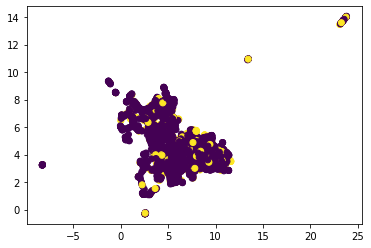

In [142]:
from umap import UMAP
umap = UMAP(n_components=2, init='random', random_state=0)

projections_umap = umap.fit_transform(embeddings)
plt.scatter(projections_umap[:,0], projections_umap[:,1], c = artist_genders)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


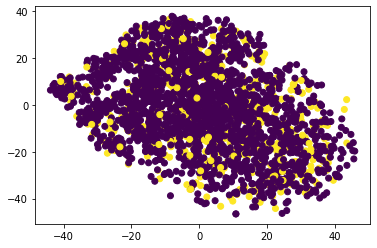

In [146]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
projections_tsne = tsne.fit_transform(embeddings)
plt.scatter(projections_tsne[:,0], projections_tsne[:,1], c = artist_genders)

## Data

In [ ]:
%cd /content/drive/MyDrive/Master\ Thesis/data

In [ ]:
data_predictions = pd.read_csv("predictions_lyrics_tags.csv").drop(['Unnamed: 0'],axis=1)
topn=100
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user, user_prediction in data_predictions.groupby('user_id'):
    results_df = results_df.append(user_prediction.sort_values('count', ascending=False).head(topn))
    

In [ ]:
data_interaction_new = results_df.merge(data_items_eval, on = 'track_id')

In [ ]:
data_interaction_new[data_interaction_new.user_id == 119741]

In [ ]:
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1)


In [ ]:
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_all_info = data_all_info[['track_artist', 'gender_artist', 'track_id']]

data_classification = data_all_info
replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
#data_classification['gender_user'] = data_classification['gender_user'].replace(replace_dict1)
data_classification['gender_artist'] = data_classification['gender_artist'].replace(replace_dict2)
data_classification = data_classification.merge(data_tracks_tags_lyrics[['track_id', 'tags', 'abstract']], on = 'track_id')
data_classification

In [ ]:
data_user = pd.read_csv("data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_user.columns = ['user_id', 'gender_user']

In [ ]:
data_classification = data_all_info
replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
#data_classification['gender_user'] = data_classification['gender_user'].replace(replace_dict1)
data_classification['gender_artist'] = data_classification['gender_artist'].replace(replace_dict2)
data_classification = data_classification.merge(data_tracks_tags_lyrics[['track_id', 'tags', 'abstract']], on = 'track_id')
data_classification

In [ ]:
df_tmp = pd.merge(data_interaction_train, data_user, 'inner')
df_all = pd.merge(df_tmp, data_all_info, on = 'track_id').drop_duplicates()

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

df_train = df_all[df_all['count'] == 1]

In [ ]:
df_tmp = pd.merge(data_interaction_test, data_user, 'inner')
df_all = pd.merge(df_tmp, data_all_info, on = 'track_id').drop_duplicates()

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

df_test = df_all[df_all['count'] == 1]

In [ ]:
df_tmp = pd.merge(results_df, data_user, 'inner')
df_all = pd.merge(df_tmp, data_all_info, on = 'track_id').drop_duplicates()

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

df_rec = df_all

# BERT classification model

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks

In [ ]:
import pickle
import pandas as pd


from smooth_gradient import SmoothGradient
from integrated_gradient import IntegratedGradient

import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import DistilBertConfig, DistilBertTokenizer
from transformers import BertTokenizer, BertModel, AdamW

from IPython.display import display, HTML

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes=2):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('prajjwal1/bert-tiny')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    y, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False
    )
    pooled_output = y[:,0,:]
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
import torch
from torch.nn.functional import softmax

import matplotlib
import matplotlib.pyplot as plt


class SaliencyInterpreter:
    def __init__(self,
                 model,
                 criterion,
                 tokenizer,
                 show_progress=True,
                 **kwargs):

        """
        :param model: nn.Module object - can be HuggingFace's model or custom one.
        :param criterion: torch criterion used to train your model.
        :param tokenizer: HuggingFace's tokenizer.
        :param show_progress: bool flag to show tqdm progress bar.
        :param kwargs:
            encoder: string indicates the HuggingFace's encoder, that has 'embeddings' attribute. Used
                if your model doesn't have 'get_input_embeddings' method to get access to encoder embeddings
        """

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.model.eval()
        self.criterion = criterion
        self.tokenizer = tokenizer
        self.show_progress = show_progress
        self.kwargs = kwargs
        # to save outputs in saliency_interpret
        self.batch_output = None

    def _get_gradients(self, batch):
        # set requires_grad to true for all parameters, but save original values to
        # restore them later
        original_param_name_to_requires_grad_dict = {}
        for param_name, param in self.model.named_parameters():
            original_param_name_to_requires_grad_dict[param_name] = param.requires_grad
            param.requires_grad = True
        embedding_gradients = []
        hooks = self._register_embedding_gradient_hooks(embedding_gradients)

        loss = self.forward_step(batch)

        self.model.zero_grad()
        loss.backward()

        for hook in hooks:
            hook.remove()

        # restore the original requires_grad values of the parameters
        for param_name, param in self.model.named_parameters():
            param.requires_grad = original_param_name_to_requires_grad_dict[param_name]

        return embedding_gradients[0]

    def _register_embedding_gradient_hooks(self, embedding_gradients):
        """
        Registers a backward hook on the
        Used to save the gradients of the embeddings for use in get_gradients()
        When there are multiple inputs (e.g., a passage and question), the hook
        will be called multiple times. We append all the embeddings gradients
        to a list.
        """

        def hook_layers(module, grad_in, grad_out):
            embedding_gradients.append(grad_out[0])

        backward_hooks = []
        embedding_layer = self.get_embeddings_layer()
        backward_hooks.append(embedding_layer.register_backward_hook(hook_layers))
        return backward_hooks

    def get_embeddings_layer(self):
        if hasattr(self.model, "get_input_embeddings"):
            embedding_layer = self.model.get_input_embeddings()
        else:
            encoder_attribute = self.kwargs.get("encoder")
            assert encoder_attribute, "Your model doesn't have 'get_input_embeddings' method, thus you " \
                "have provide 'encoder' key argument while initializing SaliencyInterpreter object"
            embedding_layer = getattr(self.model, encoder_attribute).embeddings
        return embedding_layer

    def colorize(self, instance, skip_special_tokens=False):

        special_tokens = self.special_tokens

        word_cmap = matplotlib.cm.Blues
        prob_cmap = matplotlib.cm.Greens
        template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
        colored_string = ''
        # Use a matplotlib normalizer in order to make clearer the difference between values
        normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=word_cmap).to_rgba(instance['grad'])
        for word, color in zip(instance['tokens'], normalized_and_mapped):
            if word in special_tokens and skip_special_tokens:
                continue
            # handle wordpieces
            word = word.replace("##", "") if "##" in word else ' ' + word
            color = matplotlib.colors.rgb2hex(color[:3])
            colored_string += template.format(color, word)
        colored_string += template.format(0, "    Label: {} |".format(instance['label']))
        prob = instance['prob']
        color = matplotlib.colors.rgb2hex(prob_cmap(prob)[:3])
        colored_string += template.format(color, "{:.2f}%".format(instance['prob']*100)) + '|'
        return colored_string

    @property
    def special_tokens(self):
        """
        Some tokenizers don't have 'eos_token' and 'bos_token' attributes.
        So needed we some trick to get them.
        """
        if self.tokenizer.bos_token is None or self.tokenizer.eos_token is None:
            special_tokens = self.tokenizer.build_inputs_with_special_tokens([])
            special_tokens_ids = self.tokenizer.convert_ids_to_tokens(special_tokens)
            self.tokenizer.bos_token, self.tokenizer.eos_token = special_tokens_ids

        special_tokens = self.tokenizer.eos_token, self.tokenizer.bos_token
        return special_tokens

    def forward_step(self, batch):
        """
        If your model receive inputs in another way or you computing not
         like in this example simply override this method. It should return the batch loss
        :param batch: batch returned by dataloader
        :return: torch.Tensor: batch loss
        """
        input_ids = batch.get('input_ids').to(self.device)
        attention_mask = batch.get("attention_mask").to(self.device)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        label = torch.argmax(outputs, dim=1)
        batch_losses = self.criterion(outputs, label)
        loss = torch.mean(batch_losses)

        self.batch_output = [input_ids, outputs]

        return loss

    def update_output(self):
        """
        You can also override this method if you want to change the format
         of outputs. (e.g. store just gradients)
        :return: batch_output
        """

        input_ids, outputs, grads = self.batch_output

        probs = softmax(outputs, dim=-1)
        probs, labels = torch.max(probs, dim=-1)

        tokens = [
            self.tokenizer.convert_ids_to_tokens(input_ids_)
            for input_ids_ in input_ids
        ]

        embedding_grads = grads.sum(dim=2)
        # norm for each sequence
        norms = torch.norm(embedding_grads, dim=1, p=1)
        # normalizing
        for i, norm in enumerate(norms):
            embedding_grads[i] = torch.abs(embedding_grads[i]) / norm

        batch_output = []

        iterator = zip(tokens, probs, embedding_grads, labels)

        for example_tokens, example_prob, example_grad, example_label in iterator:
            example_dict = dict()
            # as we do it by batches we has a padding so we need to remove it
            example_tokens = [t for t in example_tokens if t != self.tokenizer.pad_token]
            example_dict['tokens'] = example_tokens
            example_dict['grad'] = example_grad.cpu().tolist()[:len(example_tokens)]
            example_dict['label'] = example_label.item()
            example_dict['prob'] = example_prob.item()
            batch_output.append(example_dict)
        return batch_output

import torch

from tqdm import tqdm



class SmoothGradient(SaliencyInterpreter):
    """
    Interprets the prediction using SmoothGrad (https://arxiv.org/abs/1706.03825)
    Registered as a `SaliencyInterpreter` with name "smooth-gradient".
    """
    def __init__(self,
                 model,
                 criterion,
                 tokenizer,
                 stdev=0.01,
                 num_samples=20,
                 show_progress=True,
                 **kwargs):
        super().__init__(model, criterion, tokenizer, show_progress, **kwargs)
        # Hyperparameters
        self.stdev = stdev
        self.num_samples = num_samples

    def saliency_interpret(self, test_dataloader):

        instances_with_grads = []
        iterator = tqdm(test_dataloader) if self.show_progress else test_dataloader

        for batch in iterator:

            # we will store there batch outputs such as gradients, probability, tokens
            # so as each of them are used in different places, for convenience we will create
            # it as attribute:
            self.batch_output = []
            self._smooth_grads(batch)
            batch_output = self.update_output()
            instances_with_grads.extend(batch_output)

        return instances_with_grads

    def _register_forward_hook(self, stdev: float):
        """
        Register a forward hook on the embedding layer which adds random noise to every embedding.
        Used for one term in the SmoothGrad sum.
        """

        def forward_hook(module, inputs, output):
            # Random noise = N(0, stdev * (max-min))
            scale = output.detach().max() - output.detach().min()
            noise = torch.randn(output.shape).to(output.device) * stdev * scale

            # Add the random noise
            output.add_(noise)

        # Register the hook
        embedding_layer = self.get_embeddings_layer()
        handle = embedding_layer.register_forward_hook(forward_hook)
        return handle

    def _smooth_grads(self, batch):
        total_gradients = None
        for _ in range(self.num_samples):
            handle = self._register_forward_hook(self.stdev)
            grads = self._get_gradients(batch)
            handle.remove()

            # Sum gradients
            if total_gradients is None:
                total_gradients = grads
            else:
                total_gradients = total_gradients + grads

        total_gradients /= self.num_samples

        self.batch_output.append(total_gradients)

In [ ]:
data_classification = data_classification.drop_duplicates()

class_0 = data_classification[data_classification['gender_artist'] == 0]
class_1 = data_classification[data_classification['gender_artist'] == 1]
class_count_0, class_count_1 = data_classification['gender_artist'].value_counts()

class_0_under = class_0.sample(class_count_1)
test_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

dataset_train= ArtistDataset(test_under,tokenizer, 128, 'lyrics_cleaned')

dataloader_train=DataLoader(dataset=dataset_train,batch_size=32)

In [ ]:
import gc

gc.collect()

In [ ]:
device = 'cuda'

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# model = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased', 
#     num_labels = 2, 
#     output_attentions = False, 
#     output_hidden_states = False, 
# ).to(device)
model = SentimentClassifier().to('cuda')

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 20
loss_fn = nn.CrossEntropyLoss().to(device)
total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

for epoch_i in range(0, epochs):
    
    losses = []
    model.train()

    for step, batch in enumerate(dataloader_train):

        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['target'].type(torch.LongTensor).to(device)
    

        outputs = model(
          input_ids=b_input_ids,
          attention_mask=b_input_mask
        )#['logits']

        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, b_labels)

        losses.append(loss.item())

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

        optimizer.zero_grad()
    print(f"Epoch {epoch_i}, Loss {np.mean(losses)}")


In [ ]:
outputs

In [ ]:
integrated_grad = SmoothGradient(
    model, 
    loss_fn, 
    tokenizer, 
    show_progress=False,
    encoder="bert"
)
instances = integrated_grad.saliency_interpret(dataloader_train)


In [ ]:
words_male = []
words_female = []
for i in range(len(instances)):
  idx = np.argsort(instances[i]['grad'])[::-1][:10]
  if instances[i]['label'] == 0:
    words_male = words_male + [instances[i]['tokens'][val] for val in idx]
  else: 
    words_female = words_female + [instances[i]['tokens'][val] for val in idx]

words_male = [ elem for elem in words_male if elem not in ['[SEP]', '[CLS]']]
words_female = [ elem for elem in words_female if elem not in ['[SEP]', '[CLS]']]

In [ ]:
len(words_male)

In [ ]:
coloder_string = integrated_grad.colorize(instances[1])
display(HTML(coloder_string))

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join(words_female)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join(words_male)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

# Predict artist gender

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [ ]:
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_all_info = data_all_info.loc[data_all_info.artist_gender != 'other' ]

In [ ]:
input = feature_vectors

In [ ]:
df_features = pd.DataFrame()
id_col = []

for id in data_interaction_test[item_col].unique():
  id_col.append(id)
  df_features = df_features.append(pd.DataFrame(input[id][0].detach().numpy()))

df_features[item_col] = id_col

In [ ]:
df_features = pd.merge(df_features, data_all_info)

In [ ]:
df_features.loc[df_features.artist_gender == 'female', 'artist_gender'] = 0
df_features.loc[df_features.artist_gender == 'male', 'artist_gender'] = 1
df_features.artist_gender = df_features.artist_gender.astype('int')

In [ ]:
X = df_features.iloc[:,:128]
y = df_features.artist_gender
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [ ]:
#clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test.values, y_pred))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test.values, y_pred))
print("Recall: ", metrics.recall_score(y_test.values, y_pred))
print("Precision: ", metrics.precision_score(y_test.values, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp.head(10)